# Background

## Bickley Jet Experiment

This example will use a Bickley Jet flow introduced in (I.I. Rypina, M.G. Brown,F.J. Beron-Vera, H. Kocak, M.J. Olascoaga, and I.A.Udovydchenko. On the Lagrangian dynamics of atmospheric zonal jets and the permeability of the stratospheric polar vortex. *Journal of the Atmospheric Sciences*, 64(10):3595-3610, 2007.), which models a meandering jet with additional rotating vortices. It's a Hamiltonian system, where $\psi$ is the stream function

$$
\psi(x,y,t) = -U_0 L tanh(y/L) + \sum_{i=1}^3 A_i U_0 L sech^2 (y/L)cos(k_i (x-c_i t))
$$

and parameter values $U_0 = 62.66ms^{-1}$, $L = 1770km$, $A_1 = 0.0075$, $A_2 = 0.15$, $A_3 = 0.3$, $c_1 = 0.1446U_o$, $c_2 = 0.205U_0$, $c_3 = 0.461U_0$, $r_e = 6371km$, $k_1 = 2/r_e$, $k_2 = 4/r_e$, and $k_3 = 6/r_e$.

We consider the associated flow on the domain $M = [0,20] \times [-3,3]$ with periodic boundary conditions in the $x$-direction, on the time interval $t \in [0,40]$ days.

## Step 1: Import required python packages

In [1]:
""" Bickley Jet Matlab to Python conversion
- MATLAB code from FEMDL Matlab
"""
# Add path to FEMDL code 
#import sys
#sys.path.append('../../src')

# Import Statements
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.spatial import Delaunay
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import eigs
from matplotlib.tri import Triangulation

## Step 2: Define the Bickley jet vector field

In [2]:
#From experiments/bickley_jet/bickley_jet.py\
import numpy as np
def bickley_jet_vf(t,y):
    U=62.66e-6
    L=1770e-3
    c2=.205*U
    c3=.461*U
    A1=0.0075
    A2=0.15
    A3=0.3
    r0=6371e-3
    k1=2/r0
    k2=4/r0
    k3=6/r0
    #c1=c3+((np.sqrt(5)-1)/2)*(k2/k1)*(c2-c3)
    c1 = 0.1446*U

    N = int(np.round(len(y)/2));
    dy = np.zeros(2*N);
    
    dy[0:N] = (U*np.square(1/np.cosh(y[N:]/L))+(2*A1*U*np.cos(k1*(y[:N]-c1*t)) + 2*A2*U*np.cos(k2*(y[:N]-c2*t)) + 2*A3*U*np.cos(k3*(y[:N]-c3*t)))*np.tanh(y[N:]/L)*np.square(1/np.cosh(y[N:]/L)))[:,0]
    dy[N:] = (-(A1*k1*U*L*np.sin(k1*(y[:N]-c1*t)) + A2*k2*U*L*np.sin(k2*(y[:N]-c2*t)) + A3*k3*U*L*np.sin(k3*(y[:N]-c3*t)))*np.square(1/(np.cosh(y[N:]/L))))[:,0]   
    
    return dy



## Step 3: Define some functions that we will require to solve the ODE

In [3]:
#From src/normed.py
from numpy.linalg import norm
from numpy import inf
def normed(x):
    y = x/norm(x,inf)
    return y


In [4]:
#From src/flow_map.py
import sys
from numpy import conj, transpose

def flow_map(v, x, tspan):

    x0 = x[0,:]
    y0 = x[1,:]

    [Fx,Fy] = integrator(v,x0,y0,tspan)

    y =  np.array((conj(transpose(Fx)), conj(transpose(Fy))))

    return y

In [5]:
#From src/integrator.py
from scipy import integrate
from numpy import concatenate

def integrator(v, x0, y0, tspan):
    #Ps = integrate.odeint(rotating_double_gyre_vf, np.concatenate((x0,y0)), tspan, tfirst=True)
    tminmax = np.array((tspan[0],tspan[-1]))
    Ps = integrate.solve_ivp(v, tminmax, concatenate((x0,y0)), method='RK45', vectorized=True, atol=1e-3, rtol=1e-3, t_eval=tspan)
    print('Integrator: ' + Ps.message)
    F = Ps.y

    xt = F[0:len(x0),:]
    yt = F[len(x0):,:]

    return xt, yt


## Step 4: Define some functions that we will use to assemble the stiffness and mass matrices

In [6]:
#From src/gradbasis.py
from numpy import asarray, array
def gradbasis(p,t):

    v = []
    #inserting with positions rather than append to make sure order is correct
    v.insert(0, p[:,t[:,2]] - p[:,t[:,1]])
    v.insert(1, p[:,t[:,0]] - p[:,t[:,2]])
    v.insert(2, p[:,t[:,1]] - p[:,t[:,0]])
    
    v = np.asarray(v) #make as np array so indexing is normal

    area = 0.5*(-v[2,0,:]*v[1,1,:] + v[2,1,:]*v[1,0,:])

    dphi = []
    dphi.insert(0, -v[:,1,:]/(2*area))
    dphi.insert(1, v[:,0,:]/(2*area))
    dphi = np.asarray(dphi)

    area = abs(area)

    return dphi, area

In [7]:
#From src/assemble.py
from numpy import max,concatenate, ones
from scipy.sparse import csc_matrix, lil_matrix 
def assemble(p,t,pb=None,G=None):
    #def assemble(p,t,pb=None,G=None):
    n = len(p[0])
    #n = max(pb[1,:]) + 1 #number of nodes
    m = len(t)

    #use lil_matrix as they are quicker when updating element by element.
    D = lil_matrix((n, n)) 
    M = lil_matrix((n, n))

    for e in range(0,len(t)):
        ns = t[e,:]
        P = np.transpose(np.stack((np.ones(3), p[0,ns], p[1,ns])))
        area = np.abs(np.linalg.det(P))/2
        B = np.linalg.inv(P)
        grad = B[1:,:]
        N = - area*np.dot(np.transpose(grad),grad)
        K = area/12*(np.ones((3,3)) + np.eye(3))
        
        
        #TO DO: Convert code below into 2 lines using matrix functions
        D[ns[0],ns[0]] = D[ns[0],ns[0]] + N[0,0]
        D[ns[0],ns[1]] = D[ns[0],ns[1]] + N[0,1]
        D[ns[0],ns[2]] = D[ns[0],ns[2]] + N[0,2]
        D[ns[1],ns[0]] = D[ns[1],ns[0]] + N[1,0]
        D[ns[1],ns[1]] = D[ns[1],ns[1]] + N[1,1]
        D[ns[1],ns[2]] = D[ns[1],ns[2]] + N[1,2]
        D[ns[2],ns[0]] = D[ns[2],ns[0]] + N[2,0]
        D[ns[2],ns[1]] = D[ns[2],ns[1]] + N[2,1]
        D[ns[2],ns[2]] = D[ns[2],ns[2]] + N[2,2]

        M[ns[0],ns[0]] = M[ns[0],ns[0]] + K[0,0]
        M[ns[0],ns[1]] = M[ns[0],ns[1]] + K[0,1]
        M[ns[0],ns[2]] = M[ns[0],ns[2]] + K[0,2]
        M[ns[1],ns[0]] = M[ns[1],ns[0]] + K[1,0]
        M[ns[1],ns[1]] = M[ns[1],ns[1]] + K[1,1]
        M[ns[1],ns[2]] = M[ns[1],ns[2]] + K[1,2]
        M[ns[2],ns[0]] = M[ns[2],ns[0]] + K[2,0]
        M[ns[2],ns[1]] = M[ns[2],ns[1]] + K[2,1]
        M[ns[2],ns[2]] = M[ns[2],ns[2]] + K[2,2]

    return [D.tocsc(),M.tocsc()] #want to use csc matrices for speed when adding matrices together
    
    
    """n = max(pb[1,:]) + 1
    m = len(t)

    dphi, area = gradbasis(p,t)

    D = csc_matrix((n, n))
    M = csc_matrix((n, n))
    
    
    for i in range(0,3):
        for j in range(0,3):
            #Is the formula for Dij wrong?
            Dij = -area*(dphi[0,i,:]*G[:,0]*dphi[0,j,:] + dphi[0,i,:]*G[:,1]*dphi[1,j,:] + dphi[1,i,:]*G[:,1]*dphi[0,j,:] + dphi[1,i,:]*G[:,2]*dphi[1,j,:])
            Mij = area/12*np.ones(np.shape(dphi[0,i]))
            I = pb[1, t[:,i]]
            J = pb[1, t[:,j]]
            
            if (i == j):
                D = D + csc_matrix((Dij, (I,J)), shape=(n,n))           
                M = M + csc_matrix((Mij+ area/12, (I,J)), shape=(n,n))

            else:
                D = D + csc_matrix((concatenate((Dij,Dij)), (concatenate((I,J)), concatenate((J,I)))), shape=(n,n))
                M = M + csc_matrix((concatenate((Mij,Mij)), (concatenate((I,J)), concatenate((J,I)))), shape=(n,n))
    
    return [D, M]
    """

## Step 5: Set initial conditions

In [8]:
# Flow map
t0 = 0; days = 60*60*24; tf = 40*days; nt = 11 ; tspan = np.linspace(t0, tf, nt)

# Data points
nx = 100
ny= int(nx/20*6)
n = int(nx*ny); 
[X,Y] = np.meshgrid(np.linspace(0,20.01,nx),np.linspace(-3,3,ny), indexing = 'ij')
p = np.zeros((nt,2,n))
p_0 = np.concatenate((np.concatenate((X), axis=None), np.concatenate((Y), axis=None)), axis=None)
p[0] = np.reshape(p_0, (-1,n))
pb = np.array([np.arange(0,n), np.arange(0,n)])

## Step 6: Solve the ODE for each time step and save the results

In [9]:
# Time Integration
P = flow_map(bickley_jet_vf, p[0], tspan)

# Save the results in an array p
for k in range(1,nt):
    p_val = np.concatenate((np.mod(P[0][k,:],20),  P[1][k,:]), axis=None) #np.mod for boundary conditions
    p[k] = np.reshape(p_val, (-1,n))

Integrator: The solver successfully reached the end of the integration interval.


## Step 7: Plot current positions in the Eulerian frame (coloured by initial x-position)

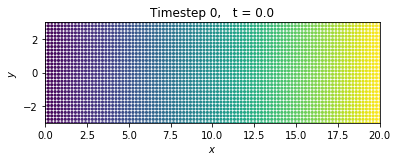

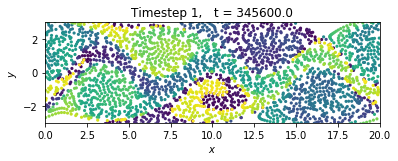

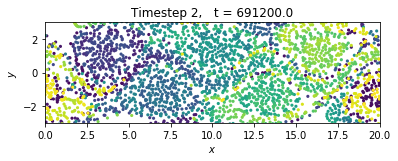

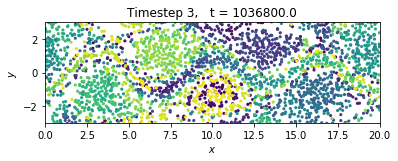

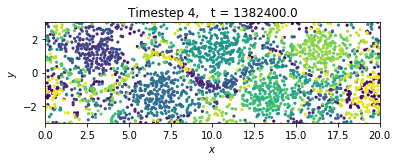

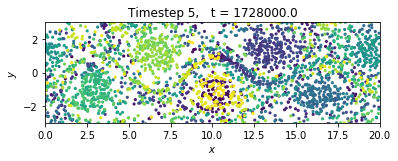

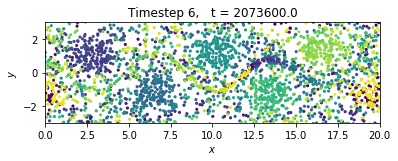

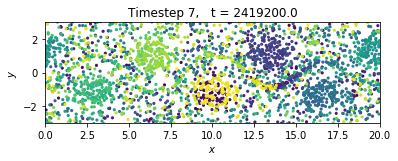

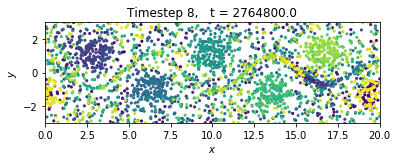

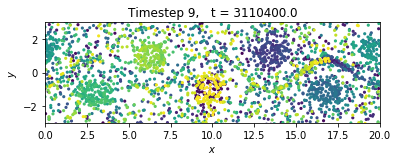

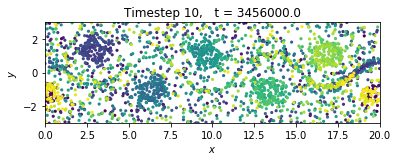

In [10]:
for i in range(nt):
    fig, ax = plt.subplots()
    ax.scatter(p[i,0,:], p[i,1,:], c=X.flatten(), s=10, edgecolors="none")
    ax.set(aspect=1, xlabel='$x$',  ylabel='$y$', xlim = [0,20], ylim=[-3,3])
    plt.title('Timestep ' + str(i) +',   t = ' + str(tspan[i]))
    plt.show()

## Step 8: Assemble the Stiffness and Mass Matrices

In [11]:
#delaunay options
options = 'Qt Qbb Qc'

t = [] #stores our Delaunay simplices

D = sp.sparse.csc_matrix((n, n))
M = sp.sparse.csc_matrix((n, n))

for k in range(0,nt):
    t.insert(k, Delaunay(np.transpose(p[k]), qhull_options=options).vertices)
    
    # Want to remove simplices with zero volume
    keep = np.ones(len(t[k]), dtype = bool)
    for i, z in enumerate(t[k]):
        if abs(np.linalg.det(np.hstack((np.transpose(p[k])[z], np.ones([1,3]).T)))) < 1E-15:
            keep[i] = False # Point is coplanar, we don't want to keep it
    t[k] = t[k][keep]

    A = np.kron([1, 0, 1], np.ones((len(t[k]),1)))
    
    [Dt, Mt] = assemble(p[k], t[k], pb, A)

    D = D + Dt
    M = M + Mt

## Step 9: Solve the Eigenproblem, plot eigenvalues and eigenvectors

In [12]:
# Solve Eigenproblem
from scipy.sparse.linalg import eigsh
L,V = eigsh(D, 20, M, sigma=0, which='LM')

pos = (-L).argsort()
lam = L[pos]
ord = V[:,pos]

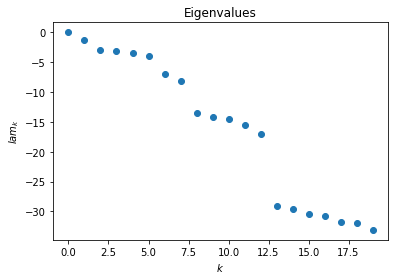

Eigenvalues: [-1.50764550e-14 -1.23152151e+00 -2.99201512e+00 -3.05529210e+00
 -3.51563621e+00 -3.99555258e+00 -7.00000595e+00 -8.21011529e+00
 -1.34970610e+01 -1.41796733e+01 -1.45750238e+01 -1.54905124e+01
 -1.70675064e+01 -2.90824526e+01 -2.96224593e+01 -3.05001675e+01
 -3.07723221e+01 -3.16985620e+01 -3.19845341e+01 -3.30946205e+01]


In [13]:
# Plot Eigenvalues
fig, lamx = plt.subplots()
lamx.scatter(np.arange(0,20), lam)
lamx.set(title='Eigenvalues', xlabel='$k$',  ylabel='$lam_k$')
plt.show()
print('Eigenvalues:',lam)

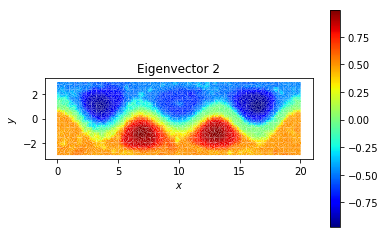

In [14]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri
from matplotlib import cm

timestep = 0
ev = 1 #eig num - 1

triang = mtri.Triangulation(p[timestep,0,:].ravel(), p[timestep,1,:].ravel(), t[timestep])

plt.figure()
plt.axes(xlabel='$x$',  ylabel='$y$', aspect='equal')
plt.title('Eigenvector ' + str(ev+1))
plt.tripcolor(triang, normed(np.real(ord[:,ev])) , cmap=cm.jet, linewidth=0.1, antialiased=True)
plt.colorbar()
plt.show()

## OTHER - TESTING

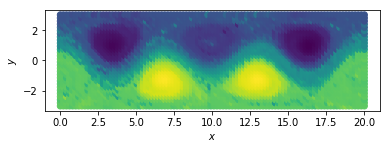

[-1.50764550e-14 -1.23152151e+00 -2.99201512e+00 -3.05529210e+00
 -3.51563621e+00 -3.99555258e+00 -7.00000595e+00 -8.21011529e+00
 -1.34970610e+01 -1.41796733e+01 -1.45750238e+01 -1.54905124e+01
 -1.70675064e+01 -2.90824526e+01 -2.96224593e+01 -3.05001675e+01
 -3.07723221e+01 -3.16985620e+01 -3.19845341e+01 -3.30946205e+01]


In [15]:
# Plot Eigenvalues
fig, lamx = plt.subplots()
lamx.scatter(p[0,0,:], p[0,1,:], c=ord[:,1].flatten())
lamx.set(xlabel='$x$',  ylabel='$y$', aspect = 'equal')
plt.show()
print(lam)

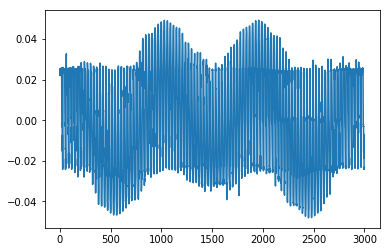

In [16]:
plt.plot(ord[:,1])